In [1]:
%%html
<style>
table {float:left}
div.jp-Cell-outputArea {display:flex}
.output {flex-direction: row}
</style>

# Analyse von Berliner Fahrradunfällen

## Initialisierung

### Schritt 1.1: Import von Paketen und Definition von Funktionen

In [2]:
# Package imports
import configparser
import ast
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import warnings

warnings.filterwarnings("ignore")  # ignore warnings


# function definitions
def addBarLabels(ax, threshold=0.01):
    for bars in ax.containers:
        labels = [f'{x:.1%}' if x > threshold else '' for x in bars.datavalues]
        ax.bar_label(bars, labels=labels, label_type='center', fontsize=8)


def addBarTotals(totals, pad):
    for i, t in enumerate(totals):
        ax.text(i, pad, f'n={t}', ha='center', fontsize=8, color='grey')#, weight='bold')


def addVerticalConnectors(ax, rows):
    height = ax.patches[0].get_height()
    stacks = len(ax.patches) // rows

    for i in range(stacks):
        for j in range(0, rows - 1):
            h0 = np.sum([ax.patches[j + rows * k].get_width() for k in range(0, i + 1)])
            h1 = np.sum([ax.patches[j + 1 + rows * k].get_width() for k in range(0, i + 1)])
            ax.plot([h0, h1], [j + height / 2, j + 1 - height / 2], color='grey', ls='--', zorder=1, linewidth=0.8)


def addHorizontalConnectors(ax, rows):
    width = ax.patches[0].get_width()
    stacks = len(ax.patches) // rows

    for i in range(stacks):
        for j in range(0, rows - 1):
            h0 = np.sum([ax.patches[j + rows * k].get_height() for k in range(0, i + 1)])
            h1 = np.sum([ax.patches[j + 1 + rows * k].get_height() for k in range(0, i + 1)])
            ax.plot([j + width / 2, j + 1 - width / 2], [h0, h1], color='grey', ls='--', zorder=1, linewidth=0.8)


def setAxisStyle(xlabel, xticklabels, x_frame_on, y_visible):
    ax.set_xlabel(xlabel)
    ax.set_xticklabels(xticklabels, rotation=0, fontsize=8)
    ax.set(frame_on=x_frame_on)
    ax.yaxis.set_visible(y_visible)

### Schritt 1.2: Laden der Konfiguration aus der `config.ini`

In [3]:
rel_path = './../'

# read local config.ini file
config = configparser.ConfigParser()
config.read(rel_path + 'config.ini')

# get from config.ini
dir_output = rel_path + config['FILE_SETTINGS']['DIR_OUTPUT']
gpkg_src = dir_output + config['FILE_SETTINGS']['GPKG_NAME']
colors3 = ast.literal_eval(config['CONFIG']['COLORS3'])
colors5 = ast.literal_eval(config['CONFIG']['COLORS5'])

### Schritt 1.3: Laden der Unfalldaten

Die Unfalldaten wurden in den vorherigen Workflow-Schritten verarbeitet und aufbereitet, um diese hinsichtlich des Tempolimits und der Radverkehrsanlagen analysieren zu können.

Die Daten befinden sich im dafür erstellen GeoPackage `map_data.gpkg` mit folgenden Layern:

| Layer | Daten | Beschreibung |
|:---|:---|:---|
| bike_accidents | Point (19557) | Unfalldaten nach Worfklow-Schritt 1, ohne abgeleitetes Tempolimit/RVA |
| **bike_accidents_ext** | **Point (19557)** | **Aufbereitete Unfalldaten nach Worfklow-Schritt 2, erweitert um Tempolimit/RVA** |
| fis_rva | LineString (18641) | Vorprozessierter FIS-Broker Datensatz zu RVA |
| fis_strassenabschnitte | LineString (43346) | Vorprozessierter FIS-Broker Datensatz zu Straßenabschnitten |
| fis_tempolimit | LineString (29424) | Vorprozessierter FIS-Broker Datensatz zu Tempolimits |

Um die Daten einfacher visualisieren zu können, wird das Tempolimit zunächst in einen `Int64` Datentyp umgewandelt. Für die Erstellung der Plots wird zwischen zwei Grundgesamtheiten unterschieden:

* **RVA**: alle Berliner Fahrradunfälle
* **Tempolimit**: nur Fahrradunfälle, wo ein Tempolimit von 30km/h oder höher relevant ist, d.h. exkl. Unfälle zwischen Fahrradfahrer:innen, Fußgänger:innen etc.

In [4]:
# read preprocessed files
df_bike_acc = gpd.read_file(gpkg_src, layer='bike_accidents_ext')
df_bike_acc['speed_der'] = df_bike_acc['speed_der'].astype('Int64')
df_bike_acc_speed = df_bike_acc.loc[df_bike_acc['speed_rel']]

***

## Heatmap

### Schritt 2.1: Erstellung je einer Kontingenztafel 

**Absolute** Unfallhäufigkeiten nach RVA/Tempolimit und Unfallschwere

In [5]:
# crosstab with absolute values
crosstab_speed = pd.crosstab(df_bike_acc_speed['UKATEGORIE'],df_bike_acc_speed['speed_der'].fillna(0),margins=True)
crosstab_speed.rename(columns={0: "NA"},inplace=True)
crosstab_rva = pd.crosstab(df_bike_acc['UKATEGORIE'],df_bike_acc['rank_rva'],margins=True)

In [6]:
# optional: print version includes margins (totals)
display(crosstab_rva)
display(crosstab_speed)

rank_rva,0,1,2,3,4,All
UKATEGORIE,,,,,,
1,9,20,1,4,6,40
2,1098,811,83,187,415,2594
3,7452,5467,513,1292,2199,16923
All,8559,6298,597,1483,2620,19557


speed_der,NA,5,10,20,30,40,50,60,70,All
UKATEGORIE,,,,,,,,,,
1,0,0,0,0,6,0,27,1,0,34
2,2,2,1,1,391,0,1379,32,5,1813
3,10,38,6,11,3469,5,10240,101,22,13902
All,12,40,7,12,3866,5,11646,134,27,15749


### Schritt 2.2: Visualisierung als Heatmaps

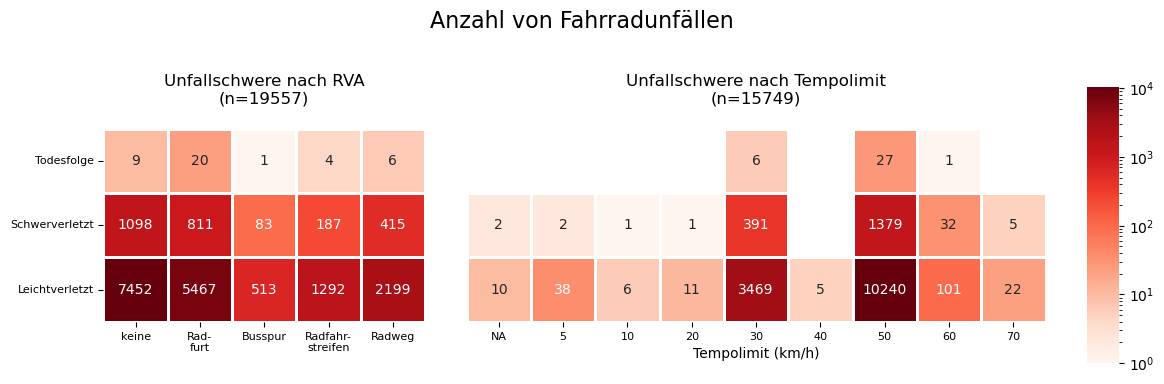

In [7]:
y_axis_labels = ['Todesfolge','Schwerverletzt','Leichtverletzt'] # labels for y-axis
x_axis_labels_rva = ['keine','Rad-\nfurt','Busspur','Radfahr-\nstreifen','Radweg'] # labels for x-axis

# start plotting...
fig,(ax1,ax2, axcb) = plt.subplots(1,3, figsize=(12, 4), gridspec_kw={'width_ratios':[0.5,0.9,0.05]})
ax1.get_shared_y_axes().join(ax2)

# RVA heatmap (without margins)
ax = sns.heatmap(crosstab_rva.iloc[0:3,0:5],cbar=False,ax=ax1,
                 cmap='Reds', annot=True, fmt="g", square=True,linewidths=2, norm=LogNorm())
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_xticklabels(x_axis_labels_rva)
ax.set_yticklabels(y_axis_labels, rotation=0,fontsize=8)
ax.xaxis.set_tick_params(labelsize=8)
ax.title.set_text(f'Unfallschwere nach RVA\n(n={len(df_bike_acc)})\n')

# speed limit heatmap (without margins)
ax = sns.heatmap(crosstab_speed.iloc[0:3,0:9],ax=ax2, cbar_ax=axcb, cmap='Reds',annot=True, fmt="g", square=True,linewidths=2, norm=LogNorm())
ax.set_ylabel('')
ax.set_xlabel('Tempolimit (km/h)',fontsize=10)
ax.set_yticks([])
ax.xaxis.set_tick_params(labelsize=8)
ax.title.set_text(f'Unfallschwere nach Tempolimit\n(n={len(df_bike_acc_speed)})\n')

# finish plotting...
plt.suptitle('Anzahl von Fahrradunfällen', fontsize=16)
plt.tight_layout(w_pad=3.0, pad=2)
#plt.show()

***

## Balkendiagramme

### Schritt 3.1: Erstellung je einer Kontingenztafel 

**Relative** Unfallhäufigkeiten nach RVA/Tempolimit und Unfallschwere, normalisiert nach **Unfallkategorie/-schwere**

*Hinweis: für das Tempolimit werden von nun an nur noch Unfälle in 30er, 50er und 60er Zonen berücksichtigt, da für die anderen Tempolimits die Anzahl an Unfällen zu gering ist*

In [8]:
# crosstab with percentage values (filtered for speed limits 30, 50, 60)
# -> normalized by index
df_bike_acc_speed_sel = df_bike_acc_speed[df_bike_acc_speed['speed_der'].isin([30,50,60])]
crosstab_speed_sel = pd.crosstab(df_bike_acc_speed_sel['UKATEGORIE'],df_bike_acc_speed_sel['speed_der'],margins=True)
crosstab_speed_sel_norm = pd.crosstab(df_bike_acc_speed_sel['UKATEGORIE'],df_bike_acc_speed_sel['speed_der'],normalize='index')
crosstab_rva_norm = pd.crosstab(df_bike_acc['UKATEGORIE'],df_bike_acc['rank_rva'],normalize='index')

In [9]:
# optional
display(crosstab_rva_norm)
display(crosstab_speed_sel_norm)

rank_rva,0,1,2,3,4
UKATEGORIE,,,,,
1,0.225000,0.500000,0.025000,0.100000,0.150000
2,0.423285,0.312645,0.031997,0.072089,0.159985
3,0.440347,0.323051,0.030314,0.076346,0.129941


speed_der,30,50,60
UKATEGORIE,,,
1,0.176471,0.794118,0.029412
2,0.216981,0.765261,0.017758
3,0.251195,0.741492,0.007314


### Schritt 3.2: Visualisierung Balkendiagramme

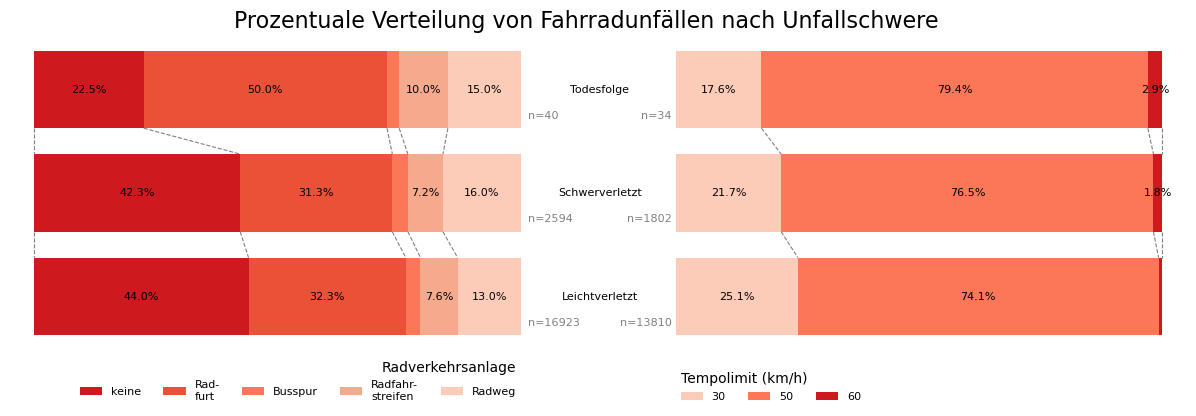

In [10]:
# RVA plot from right to left -> reverse data
crosstab_rva_norm_rev = crosstab_rva_norm[crosstab_rva_norm.columns[::-1]]
labels_rva = reversed(x_axis_labels_rva)

# get totals for each stacked bar
totals_rva = crosstab_rva['All'][0:3]
totals_speed = crosstab_speed_sel['All'][0:3]

# start plotting...
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 4))

# RVA horizontal bars
ax = crosstab_rva_norm_rev.plot.barh(stacked=True, color=colors5, ax=ax1,  width=0.75)
addBarLabels(ax,0.04)
addVerticalConnectors(ax, len(crosstab_rva_norm_rev))
ax.axis('off')
ax.invert_yaxis()
ax.invert_xaxis()

# add legend for RVA
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(reversed(handles), reversed([w.replace('-\nss', '') for w in labels_rva]),
                bbox_to_anchor=(1.01,-0.15), loc='lower right',
                ncol = 5, frameon=False, title='Radverkehrsanlage', fontsize=8)
leg._legend_box.align = "right"

# add y labels and totals in between the bars
for yloc, state in enumerate(y_axis_labels):
    ax.annotate(state, (0.5, yloc), xycoords=('figure fraction', 'data'),
                fontsize=8, ha='center', va='center')
    ax.annotate(f'n={totals_rva[yloc+1]}', (0.44, yloc+.25), xycoords=('figure fraction', 'data'),
                fontsize=8, color='grey', ha='left', va='center')
    ax.annotate(f'n={totals_speed[yloc + 1]}', (0.56, yloc + .25), xycoords=('figure fraction', 'data'),
                fontsize=8, color='grey', ha='right', va='center')

# speed limit horizontal bars
ax = crosstab_speed_sel_norm.plot.barh(stacked=True, color=colors3, ax=ax2,  width=0.75)
addBarLabels(ax)
addVerticalConnectors(ax, len(crosstab_speed_sel_norm))
ax.axis('off')
ax.invert_yaxis()

# add legend for speed limit
leg = ax.legend(bbox_to_anchor=(-0.01,-0.15), loc='lower left',
                ncol=3, frameon=False, title='Tempolimit (km/h)', fontsize=8)
leg._legend_box.align = "left"

# finish plotting...
plt.suptitle('Prozentuale Verteilung von Fahrradunfällen nach Unfallschwere', fontsize=16)
plt.tight_layout(w_pad=4, pad=0)

***

## Säulendiagramme

### Schritt 4.1: Erstellung je einer Kontingenztafel 

**Relative** Unfallhäufigkeiten nach RVA/Tempolimit und Unfallschwere, normalisiert nach **RVA/Tempolimit**

In [11]:
# crosstab with percentage values (filtered for speed limits 30, 50, 60)
# -> normalized by columns
crosstab_speed_sel_norm = pd.crosstab(df_bike_acc_speed_sel['UKATEGORIE'],df_bike_acc_speed_sel['speed_der'],normalize='columns').sort_index(ascending=False)
crosstab_rva_norm = pd.crosstab(df_bike_acc['UKATEGORIE'],df_bike_acc['rank_rva'],normalize='columns').sort_index(ascending=False)

In [12]:
# optional
display(crosstab_rva_norm)
display(crosstab_speed_sel_norm)

rank_rva,0,1,2,3,4
UKATEGORIE,,,,,
3,0.870662,0.868053,0.859296,0.871207,0.839313
2,0.128286,0.128771,0.139028,0.126096,0.158397
1,0.001052,0.003176,0.001675,0.002697,0.002290


speed_der,30,50,60
UKATEGORIE,,,
3,0.897310,0.879272,0.753731
2,0.101138,0.118410,0.238806
1,0.001552,0.002318,0.007463


### Schritt 4.2: Visualisierung Säulendiagramme

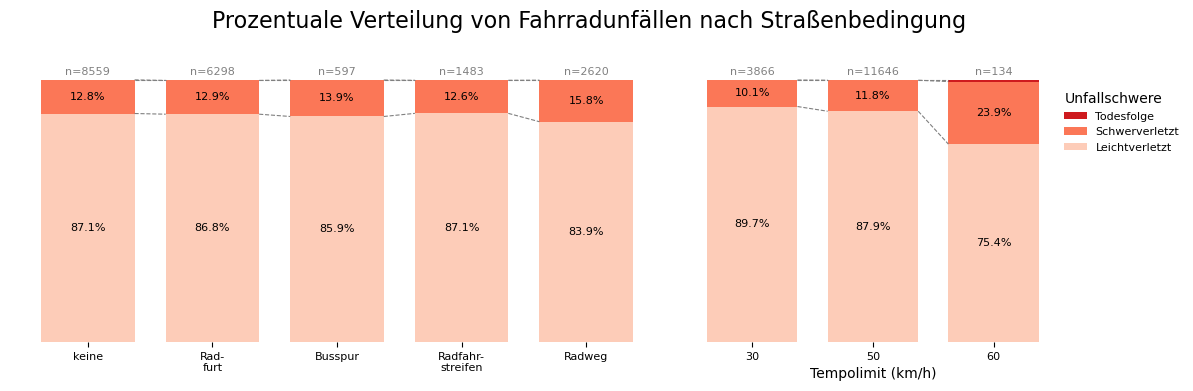

In [13]:
# start plotting...
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 4), gridspec_kw={'width_ratios':[1,0.6]})

# stacked bars for RVA
ax = crosstab_rva_norm.T.plot.bar(stacked=True, ax=ax1, legend=False, width=0.75, color=colors3)
addBarLabels(ax)
addHorizontalConnectors(ax, len(crosstab_rva_norm.T))
addBarTotals(crosstab_rva.loc['All'][0:5], 1.02)
setAxisStyle('', x_axis_labels_rva, False, False)

# stacked bars for speed limit
ax = crosstab_speed_sel_norm.T.plot.bar(stacked=True, ax=ax2, legend=False, width=0.75, color=colors3)
addBarLabels(ax)
addHorizontalConnectors(ax, len(crosstab_speed_sel_norm.T))
addBarTotals(crosstab_speed_sel.loc['All'][0:3], 1.02)
setAxisStyle('Tempolimit (km/h)', ax.get_xticklabels(), False, False)

# create joint legend
handles, labels = ax.get_legend_handles_labels()
leg = fig.legend([ax1, ax2], handles=reversed(handles), labels=y_axis_labels,
           loc=1, bbox_to_anchor=(1,0.8),
           frameon=False, title='Unfallschwere', fontsize=8)
leg._legend_box.align = "left"

# finish plotting...
plt.suptitle('Prozentuale Verteilung von Fahrradunfällen nach Straßenbedingung', fontsize=16)
plt.tight_layout(w_pad=1, pad=1.5)
fig.subplots_adjust(right=0.9)

***

## Statistik

### Schritt 5: Ermittlung des Rangkorrelationskoeffizient nach Spearman

In [14]:
res_speed = stats.spearmanr(df_bike_acc['UKATEGORIE'], df_bike_acc['rank_rva'])
print(f'Correlation (UKATEGORIE x RVA): {res_speed.correlation:.5f}, p-value: {res_speed.pvalue:.5f}')

res_speed = stats.spearmanr(df_bike_acc_speed_sel['UKATEGORIE'], df_bike_acc_speed_sel['speed_der'])
print(f'Correlation (UKATEGORIE x Speed): {res_speed.correlation:.5f}, p-value: {res_speed.pvalue:.5f}')

Correlation (UKATEGORIE x RVA): -0.02168, p-value: 0.00243
Correlation (UKATEGORIE x Speed): -0.03153, p-value: 0.00008


|  | RVA | Tempolimit |
|--:|:--:|:--:|
|$r_s$|-0.02121|-0.03153|
|p-Wert|0.00301|0.00008|

**Ergebnis**: 

* für beide Faktoren (RVA und Tempolimit) ist der Rangkorrelationskoeffizient $r_s < 0.1$. Es besteht keine Korrelation mit der Unfallschwere
* für beide Faktoren (RVA und Tempolimit) liegt der p-Wert unter dem Signifikanzniveau von $\alpha = 0.05$, d.h. das Ergebnis ist statistisch signifikant

***

# Ausblick: Analyse nach Unfallkategorie

# Säulendiagramme

### Schritt 6.1: Erstellung je einer Kontingenztafel 

**Relative** Unfallhäufigkeiten nach RVA/Tempolimit und **Unfallkategorie**, normalisiert nach **RVA/Tempolimit**

In [15]:
# crosstab with percentage values (filtered for speed limits 30, 50, 60)
# -> normalized by columns
crosstab_speed_sel = pd.crosstab(df_bike_acc_speed_sel['UART'],df_bike_acc_speed_sel['speed_der'],margins=True)

crosstab_speed_sel_norm = pd.crosstab(df_bike_acc_speed_sel['UART'],df_bike_acc_speed_sel['speed_der'],normalize='columns').sort_index(ascending=False)
crosstab_rva_norm = pd.crosstab(df_bike_acc['UART'],df_bike_acc['rank_rva'],normalize='columns').sort_index(ascending=False)

In [16]:
display(crosstab_rva_norm)
display(crosstab_speed_sel_norm)

rank_rva,0,1,2,3,4
UART,,,,,
9,0.000584,0.000159,0.001675,0.000000,0.002290
8,0.002687,0.001270,0.000000,0.002697,0.002672
7,0.002687,0.000318,0.001675,0.001349,0.004962
6,0.058068,0.025564,0.102178,0.066757,0.111450
5,0.422713,0.789457,0.264657,0.315577,0.385115
4,0.021498,0.004922,0.011725,0.014160,0.035878
3,0.064844,0.023500,0.135678,0.104518,0.085878
2,0.073607,0.040489,0.092127,0.089009,0.052290
1,0.190326,0.005557,0.232831,0.215779,0.096183


speed_der,30,50,60
UART,,,
9,0.000000,0.000086,0.000000
8,0.000000,0.000773,0.000000
7,0.000259,0.000086,0.000000
6,0.003363,0.002233,0.000000
5,0.466374,0.675082,0.813433
4,0.028195,0.005839,0.000000
3,0.049664,0.060708,0.044776
2,0.080704,0.064314,0.052239
1,0.290222,0.105530,0.007463


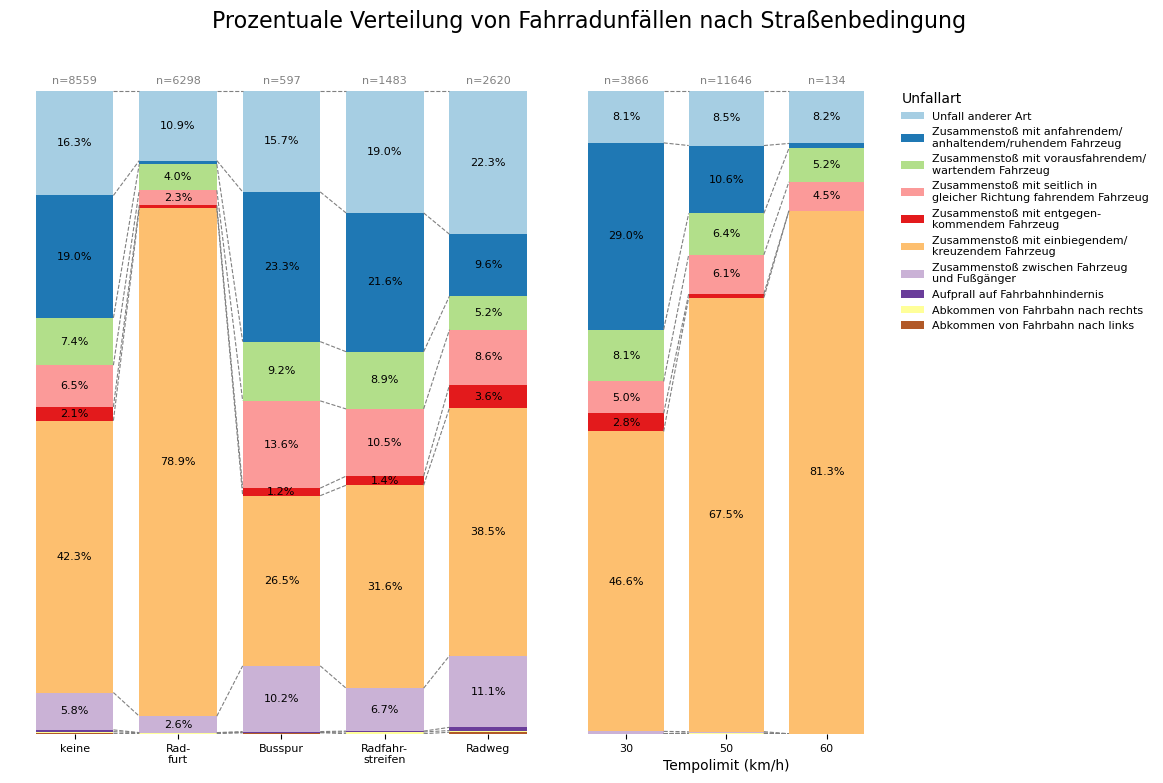

In [17]:
y_axis_labels = ['Unfall anderer Art',
                 'Zusammenstoß mit anfahrendem/\nanhaltendem/ruhendem Fahrzeug',
                 'Zusammenstoß mit vorausfahrendem/\nwartendem Fahrzeug',
                 'Zusammenstoß mit seitlich in\ngleicher Richtung fahrendem Fahrzeug',
                 'Zusammenstoß mit entgegen-\nkommendem Fahrzeug',
                 'Zusammenstoß mit einbiegendem/\nkreuzendem Fahrzeug',
                 'Zusammenstoß zwischen Fahrzeug\nund Fußgänger',
                 'Aufprall auf Fahrbahnhindernis',
                 'Abkommen von Fahrbahn nach rechts',
                 'Abkommen von Fahrbahn nach links'] # labels for y-axis

cmap = plt.get_cmap("Paired")
y = crosstab_rva_norm.index
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# start plotting...
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 8), gridspec_kw={'width_ratios':[1,0.6]})

# stacked bars for RVA
ax = crosstab_rva_norm.T.plot.bar(stacked=True, ax=ax1, legend=False, width=0.75, color=cmap(rescale(y)))
addBarLabels(ax)
addHorizontalConnectors(ax, len(crosstab_rva_norm.T))
addBarTotals(crosstab_rva.loc['All'][0:5], 1.01)
setAxisStyle('', x_axis_labels_rva, False, False)

# stacked bars for speed limit
ax = crosstab_speed_sel_norm.T.plot.bar(stacked=True, ax=ax2, legend=False, width=0.75, color=cmap(rescale(y)))
addBarLabels(ax)
addHorizontalConnectors(ax, len(crosstab_speed_sel_norm.T))
addBarTotals(crosstab_speed_sel.loc['All'][0:3], 1.01)
setAxisStyle('Tempolimit (km/h)', ax.get_xticklabels(), False, False)

# create joint legend
handles, labels = ax.get_legend_handles_labels()
leg = fig.legend([ax1, ax2], handles=reversed(handles), labels=y_axis_labels,
           loc=1, bbox_to_anchor=(0.975,0.89),
           frameon=False, title='Unfallart', fontsize=8)
leg._legend_box.align = "left"

# finish plotting...
plt.suptitle('Prozentuale Verteilung von Fahrradunfällen nach Straßenbedingung', fontsize=16)
plt.tight_layout(w_pad=1, pad=1.5)
fig.subplots_adjust(right=0.75)